In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


In [15]:
data = pd.read_csv('puskesmas.csv')
data[['Tekanan Sistolik', 'Tekanan Diastolik']] = data['Tekanan Darah'].str.split('/', expand=True)
data['Tekanan Sistolik'] = data['Tekanan Sistolik'].astype(int)
data['Tekanan Diastolik'] = data['Tekanan Diastolik'].astype(int)
data = data.drop(columns=['Tekanan Darah'])

In [16]:
kategori_columns = ['Jenis Kelamin', 'Riwayat Hipertensi', 'Riwayat Penyakit Jantung', 
                    'Sudah Menikah', 'Riwayat Stroke', 'Riwayat merokok']
for col in data.columns:
    if col not in kategori_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

In [17]:
data['Jenis Kelamin'] = data['Jenis Kelamin'].replace({'Laki-laki':0,'Perempuan':1}).astype(np.uint8)
data['Riwayat Hipertensi'] = data['Riwayat Hipertensi'].replace({'tidak':0,'ya':1}).astype(np.uint8)
data['Riwayat Penyakit Jantung'] = data['Riwayat Penyakit Jantung'].replace({'tidak':0,'ya':1}).astype(np.uint8)
data['Sudah Menikah'] = data['Sudah Menikah'].replace({'tidak':0,'ya':1}).astype(np.uint8)
data['Riwayat Stroke'] = data['Riwayat Stroke'].replace({'tidak':0,'ya':1}).astype(np.uint8)
data['Riwayat merokok'] = data['Riwayat merokok'].replace({'tidak':0,'ya':1}).astype(np.uint8)

/tmp/ipykernel_2366/2592194176.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Jenis Kelamin'] = data['Jenis Kelamin'].replace({'Laki-laki':0,'Perempuan':1}).astype(np.uint8)
/tmp/ipykernel_2366/2592194176.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Riwayat Hipertensi'] = data['Riwayat Hipertensi'].replace({'tidak':0,'ya':1}).astype(np.uint8)
/tmp/ipykernel_2366/2592194176.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior

In [18]:
data['Riwayat Stroke'].value_counts()

Riwayat Stroke
0    183
1     37
Name: count, dtype: int64

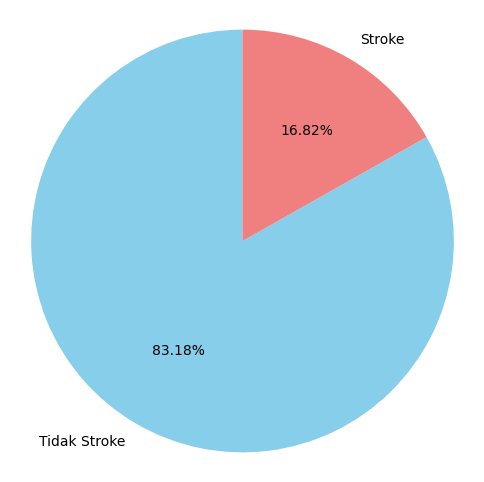

# samples associated with no stroke: 183
# samples associated with stroke: 37


In [19]:
class_occur = data['Riwayat Stroke'].value_counts()
class_names = ['Tidak Stroke','Stroke']
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%', startangle=90, colors=['skyblue', 'lightcoral'])
ax.axis('equal')
plt.show()
print("# samples associated with no stroke: {}".format(class_occur[0]))
print("# samples associated with stroke: {}".format(class_occur[1]))

In [20]:
X = data[['Jenis Kelamin', 'Usia', 'Riwayat Hipertensi', 
        'Riwayat Penyakit Jantung', 'Sudah Menikah', 'Berat Badan', 
        'Riwayat merokok', 'Detak Jantung', 'Saturasi Oksigen', 
        'Suhu Tubuh', 'Tekanan Sistolik', 'Tekanan Diastolik']]
y = data['Riwayat Stroke']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
smote = SMOTE()
X_resample, y_resample = smote.fit_resample(X_train, y_train)

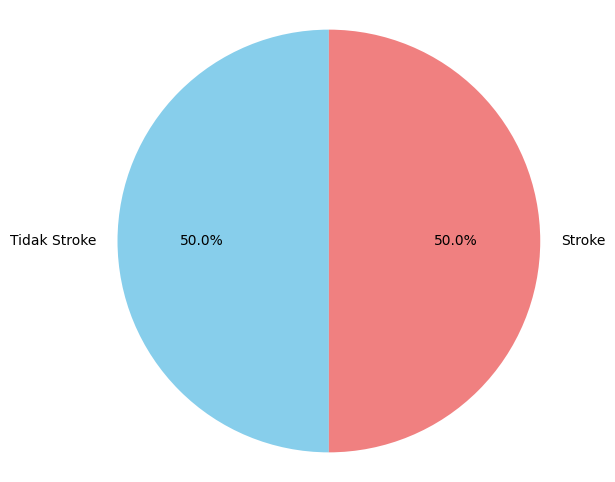

In [22]:
from collections import Counter

distribution = Counter(y_resample)

labels = ['Tidak Stroke', 'Stroke']
counts = [distribution[0], distribution[1]]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.axis('equal')
plt.show()

In [23]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    oob_score=True,
    random_state=42
)

In [24]:
clf.fit(X_resample, y_resample)

RandomForestClassifier(max_depth=5, oob_score=True, random_state=42)

In [25]:
# Normal
y_pred = clf.predict(X_test)

# Print OOB score
print(f"OOB score (Normal): {clf.oob_score_:.3f}")

# Confusion matrix
print("Confusion Matrix (Normal):")
print(confusion_matrix(y_test, y_pred))

# Detailed metrics
print("\nClassification Report (Normal):")
print(classification_report(y_test, y_pred))

OOB score (Normal): 0.945
Confusion Matrix (Normal):
[[53  2]
 [ 5  6]]

Classification Report (Normal):
              precision    recall  f1-score   support

           0       0.91      0.96      0.94        55
           1       0.75      0.55      0.63        11

    accuracy                           0.89        66
   macro avg       0.83      0.75      0.78        66
weighted avg       0.89      0.89      0.89        66



In [26]:
y_proba = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.3f}")
print(f"At this threshold: TPR (sensitivity) = {tpr[optimal_idx]:.3f}, FPR = {fpr[optimal_idx]:.3f}")


Optimal threshold (Youden's J): 0.362
At this threshold: TPR (sensitivity) = 0.818, FPR = 0.109


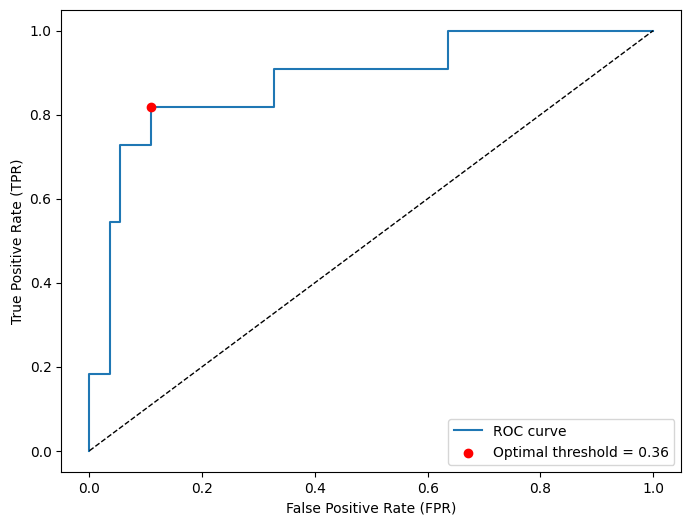

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:.2f}', zorder=10)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()


In [28]:
# Smote
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# Print OOB score
print(f"OOB score (Smote): {clf.oob_score_:.3f}")

# Confusion matrix
print("Confusion Matrix (Smote):")
print(confusion_matrix(y_test, y_pred_optimal))

# Detailed metrics
print("\nClassification Report (Smote):")
print(classification_report(y_test, y_pred_optimal))

OOB score (Smote): 0.945
Confusion Matrix (Smote):
[[49  6]
 [ 2  9]]

Classification Report (Smote):
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        55
           1       0.60      0.82      0.69        11

    accuracy                           0.88        66
   macro avg       0.78      0.85      0.81        66
weighted avg       0.90      0.88      0.89        66



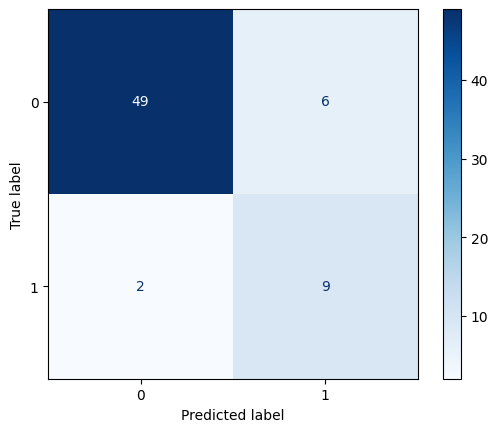

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimal, cmap="Blues")

In [25]:
test = np.array([[1, 25, 1, 1, 1, 50, 1, 98, 98, 36.5, 200, 120]])

In [26]:
y_proba_test = clf.predict_proba(test)[:, 1]
print(f"Predicted probability of stroke: {y_proba_test[0]:.3f}")

Predicted probability of stroke: 0.546


/home/rid/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [18]:
0.342

0.342

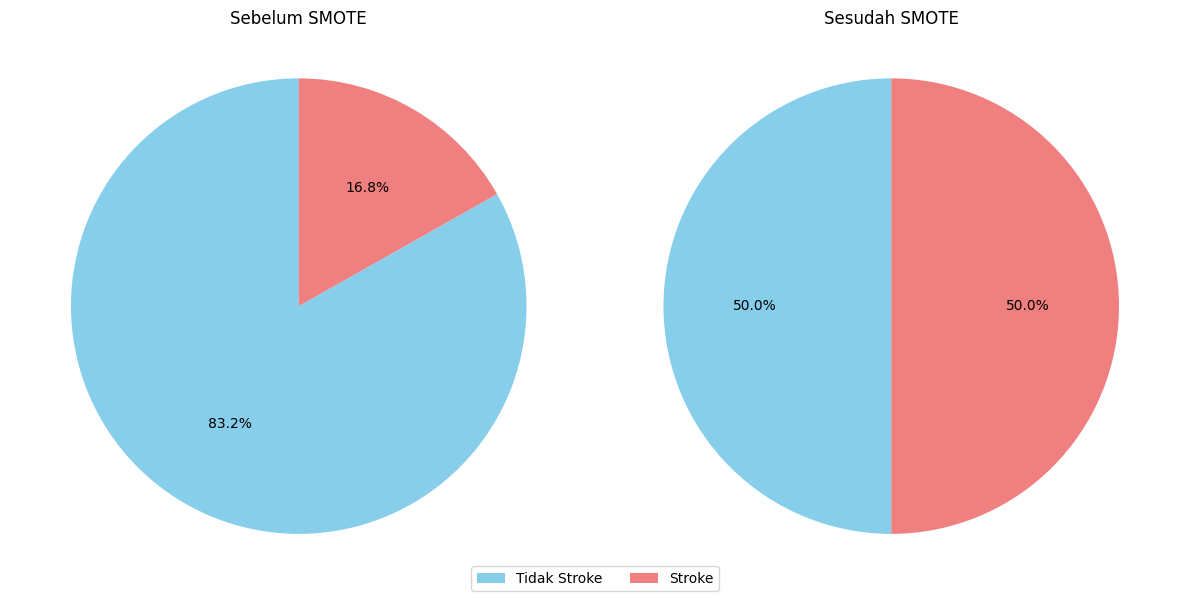

# samples associated with no stroke (before SMOTE): 183
# samples associated with stroke (before SMOTE): 37
# samples associated with no stroke (after SMOTE): 128
# samples associated with stroke (after SMOTE): 128


In [19]:
import matplotlib.pyplot as plt
from collections import Counter

# Sebelum SMOTE
class_occur = data['Riwayat Stroke'].value_counts()
counts_before = [class_occur[0], class_occur[1]]  # [Tidak Stroke, Stroke]

# Setelah SMOTE
distribution = Counter(y_resample)
counts_after = [distribution[0], distribution[1]]  # [Tidak Stroke, Stroke]

labels = ['Tidak Stroke', 'Stroke']
colors = ['skyblue', 'lightcoral']

# Buat 2 subplot berdampingan
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart sebelum SMOTE
axs[0].pie(counts_before, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
axs[0].axis('equal')
axs[0].set_title('Sebelum SMOTE')

# Pie chart setelah SMOTE
axs[1].pie(counts_after, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
axs[1].axis('equal')
axs[1].set_title('Sesudah SMOTE')

# Tambahkan legend
fig.legend(labels, loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

# Print info
print("# samples associated with no stroke (before SMOTE): {}".format(class_occur[0]))
print("# samples associated with stroke (before SMOTE): {}".format(class_occur[1]))
print("# samples associated with no stroke (after SMOTE): {}".format(distribution[0]))
print("# samples associated with stroke (after SMOTE): {}".format(distribution[1]))


In [20]:
import joblib

joblib.dump(clf, 'jurnal_rf.pkl')

['jurnal_rf.pkl']

In [21]:
clf_loaded = joblib.load('jurnal_rf.pkl')

In [ ]:
test = np.array([[1, 25, 1, 1, 1, 50, 1, 98, 98, 36.5, 150, 90]])

In [22]:
y_proba = clf.predict_proba(test)[:, 1]
print(f"Predicted probability of stroke: {y_proba[0]:.3f}")

Predicted probability of stroke: 0.240


/home/rid/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [29]:
y_proba = clf.predict_proba(test)
print(f"Predicted probability of stroke: {y_proba}")

Predicted probability of stroke: [[0.4538806 0.5461194]]


/home/rid/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [30]:
y_proba = clf.predict_proba(test)
stroke_prob = y_proba[:, 1]  # probability of stroke

threshold = 0.304

pred = (stroke_prob >= threshold).astype(int)

print(f"Predicted probability of stroke: {stroke_prob}")
print(f"Prediction based on threshold {threshold}: {pred}")

Predicted probability of stroke: [0.5461194]
Prediction based on threshold 0.304: [1]


/home/rid/miniconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [30]:
import pandas as pd
from collections import Counter

# Assuming you already have these
class_occur = data['Riwayat Stroke'].value_counts()
counts_before = [class_occur[0], class_occur[1]]  # [Tidak Stroke, Stroke]

distribution = Counter(y_resample)
counts_after = [distribution[0], distribution[1]]  # [Tidak Stroke, Stroke]

labels = ['Tidak Stroke', 'Stroke']

# Create dataframe for before SMOTE
df_before = pd.DataFrame({
    'Label': labels,
    'Jumlah': counts_before
})

# Save to CSV
df_before.to_csv('before_smote.csv', index=False)
print("✅ CSV before SMOTE saved as 'before_smote.csv'")

# Create dataframe for after SMOTE
df_after = pd.DataFrame({
    'Label': labels,
    'Jumlah': counts_after
})

# Save to CSV
df_after.to_csv('after_smote.csv', index=False)
print("✅ CSV after SMOTE saved as 'after_smote.csv'")


✅ CSV before SMOTE saved as 'before_smote.csv'
✅ CSV after SMOTE saved as 'after_smote.csv'


In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

# Assuming these are already defined
# y_proba = clf.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_proba)

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.3f}")
print(f"At this threshold: TPR (sensitivity) = {tpr[optimal_idx]:.3f}, FPR = {fpr[optimal_idx]:.3f}")

# Prepare DataFrame
df_roc = pd.DataFrame({
    'Threshold': thresholds,
    'FPR': fpr,
    'TPR': tpr,
    'J_score': j_scores
})

# Save to CSV
df_roc.to_csv('roc_thresholds_random_forest.csv', index=False)
print("✅ ROC thresholds CSV saved as 'roc_thresholds_random_forest.csv'")


Optimal threshold (Youden's J): 0.362
At this threshold: TPR (sensitivity) = 0.818, FPR = 0.109
✅ ROC thresholds CSV saved as 'roc_thresholds_random_forest.csv'
